# VQA Project

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import math
from typing import Optional, Tuple, Union
import re
import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers.activations import ACT2FN, gelu
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
)
from transformers.modeling_utils import PreTrainedModel
from transformers import RobertaConfig, RobertaForMaskedLM
from transformers import AutoTokenizer, AutoImageProcessor, ViTModel, RobertaModel
import torchtext
from vqa import VQA
import os
from torchvision.io import read_image, ImageReadMode
from tqdm.notebook import tqdm
from einops import rearrange
from torch import optim
from sklearn.model_selection import train_test_split
import json
import pickle
import copy
from vqaEval import VQAEval
import random
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-16GB'

## Data Import and Processing

In [3]:
annfileval = '../Data/v2_mscoco_val2014_annotations.json'
quesfileval = '../Data/v2_OpenEnded_mscoco_val2014_questions.json'
vqaval = VQA(annfileval, quesfileval)

loading VQA annotations and questions into memory...
0:00:04.384610
creating index...
index created!


In [4]:
VQAVal = {}
for key in vqaval.qa.keys():
    VQAVal[key] = {}
    VQAVal[key]['image_id'] = vqaval.qqa[key]['image_id']
    VQAVal[key]['question'] = vqaval.qqa[key]['question']
    VQAVal[key]['answer'] = vqaval.qa[key]['multiple_choice_answer']

In [5]:
fl = open('../Data/vocabAnswers.pickle', 'rb')
vocabAns = pickle.load(fl)
fl.close()

fl = open('../Data/quesids.pickle', 'rb')
sQuesIDs = pickle.load(fl)
fl.close()

In [6]:
data_size = {
    'sval': len(sQuesIDs),
    'val': len(VQAVal)
}

In [7]:
print(data_size)

{'sval': 53589, 'val': 214354}


In [8]:
quesIDsval = list(VQAVal.keys())

In [9]:
max_ques_length = 40

In [10]:
VQAVal[quesIDsval[0]]

{'image_id': 262148, 'question': 'Where is he looking?', 'answer': 'down'}

In [11]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
imgprocessor = AutoImageProcessor.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [12]:
class VQADataset(Dataset):
  def __init__(self, data, qids, small=True):

    super(VQADataset, self).__init__()
    self.data_dict = data
    self.qids = qids
    self.folder = 'val2014Eval'
    if not small:
        self.folder = 'val2014'
    
  def __len__(self):

    return len(self.qids)
  
  def __getitem__(self, index):
    
    label = torch.tensor(vocabAns[self.data_dict[self.qids[index]]['answer']], dtype=torch.long)
    qid = torch.tensor(self.qids[index], dtype=torch.long)
    image = read_image(f'../Data/{self.folder}/{self.data_dict[self.qids[index]]["image_id"]}.jpg', mode=ImageReadMode.RGB)
    inp1 = imgprocessor(image, return_tensors='pt')
    inp2 = tokenizer(self.data_dict[self.qids[index]]['question'], return_tensors='pt', padding='max_length', max_length=max_ques_length, add_special_tokens=True, truncation=True)
    return {
        'px': inp1['pixel_values'].squeeze(0),
        'ids': inp2['input_ids'].squeeze(0),
        'mask': inp2['attention_mask'].squeeze(0),
        'qid': qid,
        'label': label
    }

    

BATCH_SIZE = 32

dataVal = VQADataset(data=VQAVal, qids=quesIDsval, small=False)
datasVal = VQADataset(data=VQAVal, qids=sQuesIDs)

dataloader = {
    'sval': DataLoader(dataset= datasVal, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(dataset= dataVal, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
}

## Model


### Vision Encoder

In [13]:
# customised LayerNorm
class LayerNorm(nn.LayerNorm):
    # We always use float32 for the LayerNorm for stable training
    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = F.layer_norm(x.to(torch.float32), self.normalized_shape, self.weight.to(torch.float32), self.bias.to(torch.float32), self.eps)
        return ret.type(orig_type)


# activations
class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class SquaredReLU(nn.Module):
    def forward(self, x: torch.Tensor):
        return torch.square(torch.relu(x))


# interpolate position embedding
def interpolate_pos_embed(orig_pos_embed, target_len):
    orig_size = int((orig_pos_embed.shape[0]) ** 0.5)
    new_size = int(target_len ** 0.5)

    if orig_size != new_size:
        orig_pos_embed = orig_pos_embed.reshape(1, orig_size, orig_size, -1).permute(0, 3, 1, 2)
        orig_pos_embed = F.interpolate(orig_pos_embed, size=(new_size, new_size), mode='bicubic', align_corners=False)
        orig_pos_embed = orig_pos_embed.permute(0, 2, 3, 1).flatten(0, 2)
        return orig_pos_embed
    else:
        return orig_pos_embed


# Adaptor design
class Adaptor(nn.Module):
    def __init__(self, embed_dim: int, norm_late=False):
        super().__init__()
        self.norm_late = norm_late
        self.adaptor = nn.Sequential(OrderedDict([
                ("down_proj", nn.Linear(embed_dim, embed_dim // 1)),
                ("sq_relu", SquaredReLU()),
                ("up_proj", nn.Linear(embed_dim // 1, embed_dim))
            ])
        )
        self.adaptor_ln = LayerNorm(embed_dim)

    def forward(self, hidden_states: torch.Tensor):
        if self.norm_late:
            hidden_states = self.adaptor_ln(self.adaptor(hidden_states) + hidden_states)
        else:
            hidden_states = self.adaptor(self.adaptor_ln(hidden_states)) + hidden_states
        return hidden_states

In [14]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [15]:
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.mlp = nn.Sequential(OrderedDict([
                ("c_fc", nn.Linear(d_model, d_model * 4)),
                ("gelu", QuickGELU()),
                ("c_proj", nn.Linear(d_model * 4, d_model))
            ])
        )

        self.ln_1 = LayerNorm(d_model)
        self.ln_2 = LayerNorm(d_model)

    def attention(self, x: torch.Tensor):
        return self.attn(x, x, x, need_weights=False)[0]

    def forward(self, x: torch.Tensor, mode='attention'):
        if mode == 'attention':
            return x + self.attention(self.ln_1(x))
        elif mode == 'mlp':
            return x + self.mlp(self.ln_2(x))


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int):
        super().__init__()
        self.resblocks = nn.Sequential(*[nn.ModuleList([
            ResidualAttentionBlock(width, heads), 
            Adaptor(width),
        ]) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        for resblock, adaptor in self.resblocks:
            x = resblock(x, mode='attention')
            x = adaptor(x)
            x = resblock(x, mode='mlp')
        return x

In [16]:
class Encoder(nn.Module):
  def __init__(self, chw=(3, 224, 224), n_patches=14, hidden_size=768, layers=12, heads=12):
    # Super constructor
    super(Encoder, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden = hidden_size
    self.layers = layers
    self.heads = heads
    self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)
    self.embed_proj = nn.Conv2d(self.chw[0], self.hidden, kernel_size=(self.patch_size[0], self.patch_size[1]), stride=(self.patch_size[0], self.patch_size[1]))
    self.class_token = nn.Parameter(torch.rand(1, self.hidden))

    # 3) Positional embedding
    # self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden)))
    self.pos_embed = nn.Parameter(torch.randn((197, 768)))
    self.pos_embed.requires_grad = False
    self.transformer = Transformer(self.hidden, self.layers, self.heads)
    self.ln_pre = LayerNorm(self.hidden)
    self.ln_post = LayerNorm(self.hidden)

  def forward(self, images):
    patches = self.embed_proj(images)
    tokens = patches.view(patches.shape[0], patches.shape[1], -1).transpose(1, 2)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    encoder_input = tokens + pos_embed
    encoder_input = encoder_input.transpose(0, 1)
    x = self.ln_pre(encoder_input)
    x = self.transformer(x)
    x = self.ln_post(x)
    return x

### Roberta Decoder


In [17]:
config = {
    'vocab_size': 50265,
    'hidden_size': 768,
    'max_position_embeddings': 514,
    'type_vocab_size': 1,
    'layer_norm_eps': 1e-5,
    'hidden_dropout_prob': 0.1,
    'num_attention_heads': 12,
    'vision_hidden_size': 768,
    'attention_probs_dropout_prob': 0.1,
    'intermediate_size': 768*4,
    'hidden_act': 'gelu',
    'num_hidden_layers': 12,
    'pad_token_id': 1
}

In [18]:
config = RobertaConfig().from_dict(config)

In [19]:
# Copyright (c) 2023, NVIDIA Corporation & Affiliates. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://github.com/NVlabs/prismer/blob/main/LICENSE
# Modified from: https://github.com/huggingface/transformers/blob/main/src/transformers/models/roberta/modeling_roberta.py


# from model.modules.utils import LayerNorm, Adaptor

_CHECKPOINT_FOR_DOC = "roberta-base"
_CONFIG_FOR_DOC = "RobertaConfig"
_TOKENIZER_FOR_DOC = "RobertaTokenizer"

ROBERTA_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "roberta-base",
    "roberta-large",
]


def create_position_ids_from_input_ids(input_ids, padding_idx, past_key_values_length=0):
    """
    Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx + 1. Padding symbols
    are ignored. This is modified from fairseq's `utils.make_positions`.
    """
    mask = input_ids.ne(padding_idx).int()
    incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
    return incremental_indices.long() + padding_idx


class RobertaEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        self.LayerNorm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.register_buffer(
            "token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False
        )

        self.padding_idx = config.pad_token_id
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size, padding_idx=self.padding_idx)

    def forward(self, input_ids=None):
        position_ids = create_position_ids_from_input_ids(input_ids, self.padding_idx)
        token_type_ids = torch.zeros(input_ids.size(), dtype=torch.long, device=self.position_ids.device)
        inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        embeddings += self.position_embeddings(position_ids)
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class RobertaSelfAttention(nn.Module):
    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        if is_cross_attention:
            self.key = nn.Linear(config.vision_hidden_size, self.all_head_size)
            self.value = nn.Linear(config.vision_hidden_size, self.all_head_size)
        else:
            self.key = nn.Linear(config.hidden_size, self.all_head_size)
            self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def forward(self,
                hidden_states: torch.Tensor,
                attention_mask: Optional[torch.FloatTensor] = None,
                encoder_hidden_states: Optional[torch.FloatTensor] = None
                ) -> torch.Tensor:

        q = self.query(hidden_states)

        if encoder_hidden_states is not None:
            k, v = self.key(encoder_hidden_states), self.value(encoder_hidden_states)
        else:
            k, v = self.key(hidden_states), self.value(hidden_states)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_attention_heads), (q, k, v))

        attention_scores = torch.matmul(q, k.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask
            attention_scores = torch.max(attention_scores, torch.tensor(torch.finfo(attention_scores.dtype).min))

        # Normalize the attention scores to probabilities.
        if attention_scores.dtype == torch.float16:
            attention_probs = torch.softmax(attention_scores, dim=-1, dtype=torch.float32).to(attention_scores.dtype)
        else:
            attention_probs = torch.softmax(attention_scores, dim=-1)

        attention_probs = self.dropout(attention_probs)
        out = torch.matmul(attention_probs, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return out


class RobertaSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class RobertaAttention(nn.Module):
    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.self = RobertaSelfAttention(config, is_cross_attention)
        self.output = RobertaSelfOutput(config)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        self_outputs = self.self(hidden_states, attention_mask, encoder_hidden_states)
        attention_output = self.output(self_outputs, hidden_states)
        return attention_output


class RobertaIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act]

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class RobertaOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class RobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = RobertaAttention(config)
        self.intermediate = RobertaIntermediate(config)
        self.output = RobertaOutput(config)

    def forward(self, hidden_states: torch.Tensor, attention_mask: Optional[torch.FloatTensor] = None,
                mode='attention') -> Tuple[torch.Tensor]:
        if mode == 'attention':
            return self.attention(hidden_states, attention_mask)
        elif mode == 'mlp':
            return self.output(self.intermediate(hidden_states), hidden_states)


class RobertaEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([nn.ModuleList([RobertaLayer(config),
                                                   RobertaAttention(config, is_cross_attention=True),
                                                   Adaptor(config.hidden_size, norm_late=True)
                                                   ])for _ in range(config.num_hidden_layers)])
        
        self.output_layer = RobertaLayer(config)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            output_attentions: Optional[bool] = False,
            output_hidden_states: Optional[bool] = False,
            return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:

        # text-decoder layers
        for i, (layer_module, cross_attention, adaptor) in enumerate(self.layer):
            hidden_states = layer_module(hidden_states, attention_mask, mode='attention')
            hidden_states = cross_attention(hidden_states, None, encoder_hidden_states)
            hidden_states = adaptor(hidden_states)
            hidden_states = layer_module(hidden_states, attention_mask, mode='mlp')

        # final prediction layer [no cross attention]
        hidden_states = self.output_layer(hidden_states, attention_mask, mode='attention')
        hidden_states = self.output_layer(hidden_states, attention_mask, mode='mlp')

        if not return_dict:
            return tuple(v for v in [hidden_states, output_attentions, output_hidden_states] if v is not None)

        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            hidden_states=output_attentions,
            attentions=output_hidden_states
        )


class RobertaPreTrainedModel(PreTrainedModel):
    config_class = RobertaConfig
    base_model_prefix = "roberta"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, RobertaEncoder):
            module.gradient_checkpointing = value

    def update_keys_to_ignore(self, config, del_keys_to_ignore):
        """Remove some keys from ignore list"""
        if not config.tie_word_embeddings:
            # must make a new list, or the class variable gets modified!
            self._keys_to_ignore_on_save = [k for k in self._keys_to_ignore_on_save if k not in del_keys_to_ignore]
            self._keys_to_ignore_on_load_missing = [
                k for k in self._keys_to_ignore_on_load_missing if k not in del_keys_to_ignore
            ]


class RobModel(RobertaPreTrainedModel):
    # _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.embeddings = RobertaEmbeddings(config)
        self.encoder = RobertaEncoder(config)

        # Initialize weights and apply final processing
        # self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def forward(
            self,
            input_ids: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            encoder_hidden_states: Optional[torch.Tensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:

        input_shape = input_ids.size()
        device = input_ids.device

        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)

        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape)

        embedding_output = self.embeddings(input_ids=input_ids)

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]

        if not return_dict:
            return (sequence_output, ) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

### Final Model

In [20]:
class VQAPrism(nn.Module):
    def __init__(self, config):
        super(VQAPrism, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = RobModel(config).to(device)
        self.fc = nn.Linear(768, 3000)
        self.encoder_decoder_initialize()
    
    def encoder_decoder_initialize(self):
        self.encoder.load_state_dict(torch.load('../models/vState.pth'))
        self.decoder.load_state_dict(torch.load('../models/rState.pth'))
        for name, param in self.encoder.named_parameters():
            if 'adaptor' not in name and 'ln_pre' not in name:
                param.requires_grad = False
    
        for name, param in self.decoder.named_parameters():
            if 'adaptor' not in name and '1.self' not in name and 'encoder.output_layer' not in name and '1.output' not in name:
                param.requires_grad = False
      
    def forward(self, px, ids, mask):
        encoder_hidden_states = self.encoder(px).transpose(0, 1)
        last_hidden = self.decoder(input_ids=ids, attention_mask=mask, encoder_hidden_states=encoder_hidden_states)[0]
        logits = self.fc(last_hidden[:,0,:])
        return logits

In [21]:
model = torch.load('../models/finalmodal.pth')
model = model.to(device)

## Evaluation

In [22]:
def create_results(model, data, mode='sval'):
    results = []
    qids = np.empty([0], dtype=np.int16)
    ans = np.empty([0], dtype=np.int16)
    for inputs in tqdm(data[mode]):
        px =inputs['px'].to(device)
        ids = inputs['ids'].to(device)
        mask = inputs['mask'].to(device)
        labels = inputs['label'].to(device)
        qid = inputs['qid'].to(device)
        with torch.set_grad_enabled(False):
            output = model(px=px, ids=ids, mask=mask)
            _, preds = torch.max(output, 1)
        qids = np.concatenate((qids, qid.data.cpu().numpy()), axis = 0)
        ans = np.concatenate((ans, preds.data.cpu().numpy().astype(np.int16)), axis = 0)
    for i in range(len(qids)):
        arb = {'answer': str(vocabAns.lookup_token(ans[i])), 'question_id': int(qids[i])}
        results.append(arb)
    return results
    

In [23]:
results = create_results(model, dataloader, mode='sval')

  0%|          | 0/1675 [00:00<?, ?it/s]

In [24]:
for id in tqdm(quesIDsval):
    if id not in sQuesIDs:
        arb = {'answer': 'yes', 'question_id': int(id)}
        results.append(arb)

  0%|          | 0/214354 [00:00<?, ?it/s]

In [25]:
len(results) == data_size['val']

True

In [26]:
with open("results.json", "w") as final:
    json.dump(results, final)

In [27]:
resFile = 'results.json'

In [28]:
vqaRes = vqaval.loadRes(resFile, quesfileval)

Loading and preparing results...     
DONE (t=0.79s)
creating index...
index created!


In [29]:
vqaEval = VQAEval(vqaval, vqaRes, n=2)

In [30]:
vqaEval.evaluate(sQuesIDs) 

# print accuracies
print("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))
print("Per Question Type Accuracy is the following:")
for quesType in vqaEval.accuracy['perQuestionType']:
	print("%s : %.02f" %(quesType, vqaEval.accuracy['perQuestionType'][quesType]))
print()
print("Per Answer Type Accuracy is the following:")
for ansType in vqaEval.accuracy['perAnswerType']:
	print("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
print()
# demo how to use evalQA to retrieve low score result
evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]<35]   #35 is per question percentage accuracy

computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Overall Accuracy is: 54.00

Per Question Type Accuracy is the following:
are : 69.28
is the : 71.61
are there any : 75.35
what is : 31.32
are the : 71.35
none of the above : 52.03
is that a : 70.37
is this : 75.21
how many : 41.28
what is this : 56.93
what kind of : 44.48
is there a : 68.71
what color is the : 62.60
what color is : 66.45
where is the : 24.29
is : 72.89
what is the person : 53.99
how many people are in : 46.47
are these : 77.45
is this a : 78.26
what is in the : 38.13
which : 40.09
what is the man : 51.30
how : 19.16
what is the : 36.50
what color are the : 56.26
what is the color of the : 64.02
what type of : 42.26
what brand : 30.13
what sport is : 86.32
what color : 54.60
who is : 30.21
is the person : 69.50
what : 35.47
does the : 70.29
was : 74.89
could : 77.97
is the woman : 65.04
what is the woman : 46.14
what does the : 15.23
is he : 75.13
what is on the : 27.53
does this : 71

## Error Analysis

In [31]:
imgDir = '../Data/val2014Eval/'

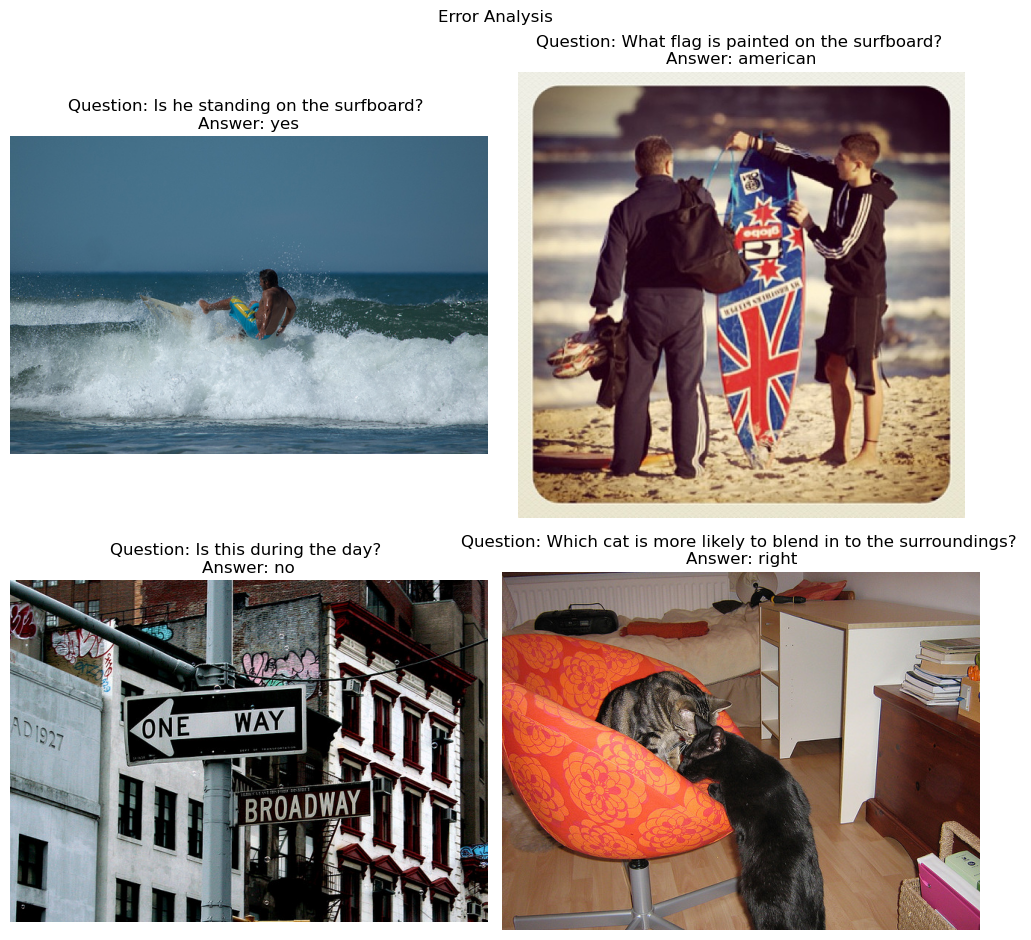

In [32]:
if len(evals) > 0:
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(10, 10)   
    for i in range(4):
        randomEval = random.choice(evals)
        randomAnn = vqaval.loadQA(randomEval)
        quesID = randomAnn[0]['question_id']
        ques = vqaval.qqa[quesID]['question']
        ann = vqaRes.loadQA(randomEval)[0]
        imgId = randomAnn[0]['image_id']
        imgFilename = str(imgId) + '.jpg'
        if os.path.isfile(imgDir + imgFilename):
            I = Image.open(imgDir + imgFilename)
            ax[0 if i<2 else 1][i%2].imshow(I)
            ax[0 if i<2 else 1][i%2].axis('off')
            ax[0 if i<2 else 1][i%2].set_title(f'Question: {ques} \nAnswer: {ann["answer"]}')
    fig.suptitle("Error Analysis")
    plt.tight_layout()
    plt.show()